# Introduction

In this notebook, we provide code for the experiments conducted in the project. For clarity, all the experiments here are done for the dataset of sequences of MNIST imeges. The same experiments may be repeated for any other dataset (Synthetic1D, Human Activity Recognition, Explosion). Moreover, they can repeated be for any other dataset or model presented in the source paper: "InDiD: Instant Disorder Detection via a Principled Neural Network".

In [2]:
# necessary imports
from utils import metrics
from utils.ensembles import EnsembleCPDModel, CusumEnsembleCPDModel
from utils.visualize import visualize_predictions

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from datetime import datetime
from typing import Any, Tuple

import yaml

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Uncertainty-aware aggregation of CP scores with CUSUM
For this experiments, we have a special 'CusumEnsembleCPDModel' class defined in ensembles.py which has almost the same interface. Note that we do not construct Detection Curves in this experiment.

In [4]:
class NEWCusumEnsembleCPDModel(EnsembleCPDModel):
    """Wrapper for cusum aproach ensemble models."""

    def __init__(
        self,
        args: dict,
        n_models: int,
        boot_sample_size: int = None,
        # scale_by_std: bool = True,
        cusum_threshold: float = 0.1,
        seed: int = 0
    ) -> None:
        """Initialize EnsembleCPDModel.

        :param args: dictionary containing core model params, learning params, loss params, etc.
        :param n_models: number of models to train
        :param boot_sample_size: size of the bootstrapped train dataset 
                                 (if None, all the models are trained on the original train dataset)
        :param scale_by_std: if True, scale the statistic by predicted std, i.e.
                                in cusum, t = series_mean[i] - series_mean[i-1]) / series_std[i],
                             else:
                                t = series_mean[i] - series_mean[i-1]
        :param susum_threshold: threshold for CUSUM algorithm
        :param seed: random seed to be fixed
        """
        super().__init__(args, n_models, boot_sample_size, seed)
        self.cusum_threshold = cusum_threshold
    
    def cusum_detector_batch(
        self, series_batch: torch.Tensor, series_std_batch: torch.Tensor
        ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Compute CUSUM change point detection.
        
        :param series_mean:
        :param series_std:
        
        :returns: change_mask 
        """
        batch_size, seq_len = series_batch.shape
        
        normal_to_change_stat = torch.zeros(batch_size, seq_len).to(series_batch.device)
        change_mask = torch.zeros(batch_size, seq_len).to(series_batch.device)
        
        for i in range(1, seq_len):            
            t = (series_batch[:, i] - 0.5) / series_std_batch[:, i] ** 2

            normal_to_change_stat[:, i] = torch.maximum(
                torch.zeros(batch_size).to(series_batch.device),
                normal_to_change_stat[:, i - 1] + t
            )
            
            is_change = normal_to_change_stat[:, i] > torch.ones(batch_size).to(series_batch.device) * self.cusum_threshold
            change_mask[is_change, i:] = True
            
        return change_mask, normal_to_change_stat
    
    def predict(self, inputs: torch.Tensor) -> torch.Tensor:
        """Make a prediction.
        
        :param inputs: input batch of sequences
        
        :returns: torch.Tensor containing predictions of all the models
        """
        
        if not self.fitted:
            print("Attention! The model is not fitted yet.")
            
        ensemble_preds = []
        
        for model in self.models_list:
            ensemble_preds.append(model(inputs))
        
        # shape is (n_models, batch_size, seq_len)
        ensemble_preds = torch.stack(ensemble_preds)

        preds_mean = torch.mean(ensemble_preds, axis=0)
        preds_std = torch.std(ensemble_preds, axis=0) 
        
        # store current predictions
        self.preds = ensemble_preds
        
        change_masks, normal_to_change_stats = self.cusum_detector_batch(preds_mean, preds_std)

        self.preds_mean = preds_mean
        self.preds_std = preds_std
        self.change_masks = change_masks
        self.normal_to_change_stats = normal_to_change_stats
        
        return change_masks

## Old CUSUM

In [13]:
model_type = "seq2seq"
experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["loss_type"] = "bce"
args_config["num_workers"] = 2
args_config["learning"]["gpus"] = 1
args_config["learning"]["epochs"] = 100

In [14]:
# choose CUSUM alarm threshold
cusum_threshold = 5.4

# Initialize model and load weights
ens_har_bce_cusum = CusumEnsembleCPDModel(args_config, n_models=10, cusum_threshold=cusum_threshold)
ens_har_bce_cusum.load_models_list("saved_models/human_activity/full_sample")

# create test_dataset and test_dataloader
test_dataset = ens_har_bce_cusum.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size = args_config["learning"]["batch_size"], shuffle=True)

In [15]:
# no need in threshold list for CUSUM-aggregated CP scores
threshold_list = [0.5]

# compute metrics
metrics_local, delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(ens_har_bce_cusum,
                                test_dataloader,
                                threshold_list,
                                device="cuda", # choose 'cpu' or 'cuda' if available
                                model_type="cusum_aggr",
                                verbose=True,
                                )

  0%|                                                                                                      | 0/1 [00:00<?, ?it/s]

TN: 162, FP: 9, FN: 20, TP: 1146, DELAY:0.24308152496814728, FP_DELAY:10.68810749053955, COVER: 0.9931280468597247


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.87s/it]

AUC: None
Time to FA 10.6881, delay detection 0.2431 for best-F1 threshold: 0.5
TN 162, FP 9, FN 20, TP 1146 for best-F1 threshold: 0.5
Max F1 0.9875: for best-F1 threshold 0.5
COVER 0.9931: for best-F1 threshold 0.5
Max COVER 0.9931: for threshold 0.5


In [23]:
# choose CUSUM alarm threshold
cusum_threshold_list = [4.75, 5.25] #np.linspace(2.5, 10, 16)

for cusum_threshold in cusum_threshold_list:
    print("cusum_threshold:", cusum_threshold)

    # Initialize model and load weights
    ens_har_bce_cusum = CusumEnsembleCPDModel(
        args_config, n_models=10, cusum_threshold=cusum_threshold, scale_by_std=True
    )
    ens_har_bce_cusum.load_models_list("saved_models/human_activity/full_sample")

    # no need in threshold list for CUSUM-aggregated CP scores
    threshold_list = [0.5]

    # compute metrics
    metrics_local, delay_list, fp_delay_list = \
        metrics.evaluation_pipeline(ens_har_bce_cusum,
                                    test_dataloader,
                                    threshold_list,
                                    device="cuda", # choose 'cpu' or 'cuda' if available
                                    model_type="cusum_aggr",
                                    verbose=True,
                                    )

cusum_threshold: 4.75


  0%|                                                                                                      | 0/1 [00:00<?, ?it/s]

TN: 162, FP: 9, FN: 20, TP: 1146, DELAY:0.24308152496814728, FP_DELAY:10.687359809875488, COVER: 0.9930740059118915


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.38s/it]


AUC: None
Time to FA 10.6874, delay detection 0.2431 for best-F1 threshold: 0.5
TN 162, FP 9, FN 20, TP 1146 for best-F1 threshold: 0.5
Max F1 0.9875: for best-F1 threshold 0.5
COVER 0.9931: for best-F1 threshold 0.5
Max COVER 0.9931: for threshold 0.5
cusum_threshold: 5.25


  0%|                                                                                                      | 0/1 [00:00<?, ?it/s]

TN: 163, FP: 2, FN: 22, TP: 1150, DELAY:0.27449512481689453, FP_DELAY:10.730740547180176, COVER: 0.9931429591296116


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:27<00:00, 27.98s/it]

AUC: None
Time to FA 10.7307, delay detection 0.2745 for best-F1 threshold: 0.5
TN 163, FP 2, FN 22, TP 1150 for best-F1 threshold: 0.5
Max F1 0.9897: for best-F1 threshold 0.5
COVER 0.9931: for best-F1 threshold 0.5
Max COVER 0.9931: for threshold 0.5


## New CUSUM

In [20]:
# choose CUSUM alarm threshold
cusum_threshold = 5.4

# Initialize model and load weights
ens_har_bce_cusum_NEW = NEWCusumEnsembleCPDModel(args_config, n_models=10, cusum_threshold=cusum_threshold)
ens_har_bce_cusum_NEW.load_models_list("saved_models/human_activity/full_sample")

In [21]:
# no need in threshold list for CUSUM-aggregated CP scores
threshold_list = [0.5]

# compute metrics
metrics_local, delay_list, fp_delay_list = \
    metrics.evaluation_pipeline(ens_har_bce_cusum_NEW,
                                test_dataloader,
                                threshold_list,
                                device="cuda", # choose 'cpu' or 'cuda' if available
                                model_type="cusum_aggr",
                                verbose=True,
                                )

  0%|                                                                                                      | 0/1 [00:00<?, ?it/s]

TN: 162, FP: 6, FN: 11, TP: 1158, DELAY:0.12640239298343658, FP_DELAY:10.546746253967285, COVER: 0.9932912114500903


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.17s/it]

AUC: None
Time to FA 10.5467, delay detection 0.1264 for best-F1 threshold: 0.5
TN 162, FP 6, FN 11, TP 1158 for best-F1 threshold: 0.5
Max F1 0.9927: for best-F1 threshold 0.5
COVER 0.9933: for best-F1 threshold 0.5
Max COVER 0.9933: for threshold 0.5


In [10]:
# choose CUSUM alarm threshold
cusum_threshold_list = [0.001, 0.01, 0.1] # np.linspace(7, 20, 14) #[1, 5, 10, 100, 1000, 10000]

for cusum_threshold in cusum_threshold_list:
    print("cusum_threshold:", cusum_threshold)

    # Initialize model and load weights
    ens_har_bce_cusum_NEW = NEWCusumEnsembleCPDModel(args_config, n_models=10, cusum_threshold=cusum_threshold)
    ens_har_bce_cusum_NEW.load_models_list("saved_models/human_activity/full_sample")

    # no need in threshold list for CUSUM-aggregated CP scores
    threshold_list = [0.5]

    # compute metrics
    metrics_local, delay_list, fp_delay_list = \
        metrics.evaluation_pipeline(ens_har_bce_cusum_NEW,
                                    test_dataloader,
                                    threshold_list,
                                    device="cuda", # choose 'cpu' or 'cuda' if available
                                    model_type="cusum_aggr",
                                    verbose=True,
                                    )

cusum_threshold: 0.001


  0%|                                                                                                      | 0/1 [00:00<?, ?it/s]

TN: 161, FP: 15, FN: 6, TP: 1155, DELAY:0.09050112217664719, FP_DELAY:10.474944114685059, COVER: 0.9940403891647595


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.96s/it]


AUC: None
Time to FA 10.4749, delay detection 0.0905 for best-F1 threshold: 0.5
TN 161, FP 15, FN 6, TP 1155 for best-F1 threshold: 0.5
Max F1 0.991: for best-F1 threshold 0.5
COVER 0.994: for best-F1 threshold 0.5
Max COVER 0.994: for threshold 0.5
cusum_threshold: 0.01


  0%|                                                                                                      | 0/1 [00:00<?, ?it/s]

TN: 161, FP: 15, FN: 6, TP: 1155, DELAY:0.09050112217664719, FP_DELAY:10.474944114685059, COVER: 0.9940403891647595


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.54s/it]


AUC: None
Time to FA 10.4749, delay detection 0.0905 for best-F1 threshold: 0.5
TN 161, FP 15, FN 6, TP 1155 for best-F1 threshold: 0.5
Max F1 0.991: for best-F1 threshold 0.5
COVER 0.994: for best-F1 threshold 0.5
Max COVER 0.994: for threshold 0.5
cusum_threshold: 0.1


  0%|                                                                                                      | 0/1 [00:00<?, ?it/s]

TN: 162, FP: 12, FN: 6, TP: 1157, DELAY:0.09124906361103058, FP_DELAY:10.492146492004395, COVER: 0.9942497093675351


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.34s/it]

AUC: None
Time to FA 10.4921, delay detection 0.0912 for best-F1 threshold: 0.5
TN 162, FP 12, FN 6, TP 1157 for best-F1 threshold: 0.5
Max F1 0.9923: for best-F1 threshold 0.5
COVER 0.9942: for best-F1 threshold 0.5
Max COVER 0.9942: for threshold 0.5


## Visualize CUSUMs

In [24]:
seq_batch, labels_batch = next(iter(test_dataloader))
seq_batch = seq_batch.to("cuda")

_ = ens_har_bce_cusum.predict(seq_batch)

old_preds_mean = ens_har_bce_cusum.preds_mean.detach().cpu()
old_preds_std = ens_har_bce_cusum.preds_std.detach().cpu()
old_cusum = ens_har_bce_cusum.normal_to_change_stats.detach().cpu()
old_cusum_preds = ens_har_bce_cusum.change_masks.detach().cpu()

_ = ens_har_bce_cusum_NEW.predict(seq_batch)

new_preds_mean = ens_har_bce_cusum_NEW.preds_mean.detach().cpu()
new_preds_std = ens_har_bce_cusum_NEW.preds_std.detach().cpu()
new_cusum = ens_har_bce_cusum_NEW.normal_to_change_stats.detach().cpu()
new_cusum_preds = ens_har_bce_cusum_NEW.change_masks.detach().cpu()

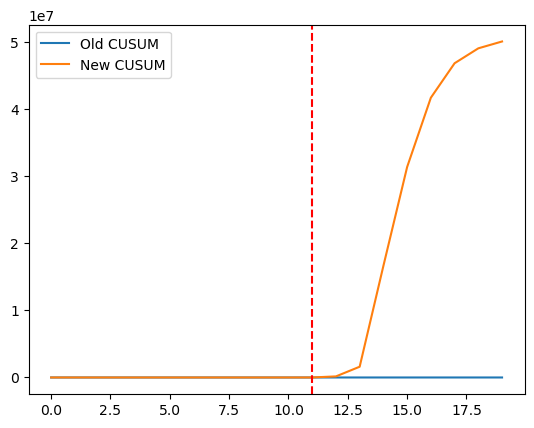

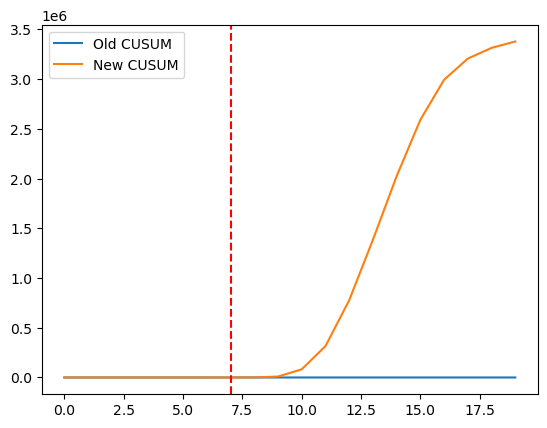

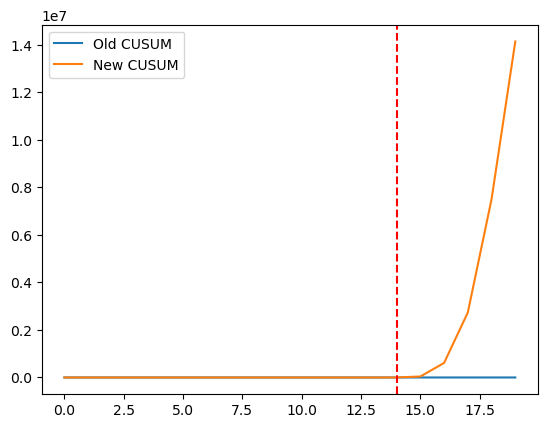

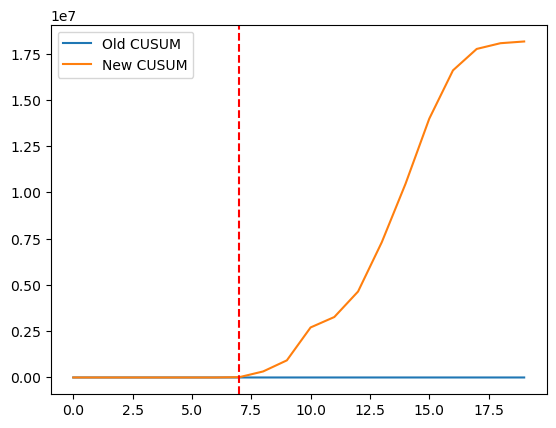

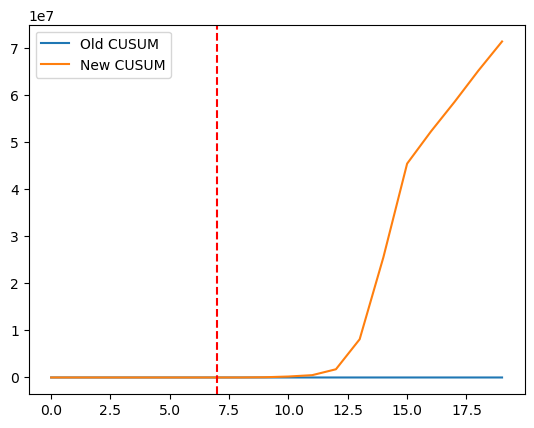

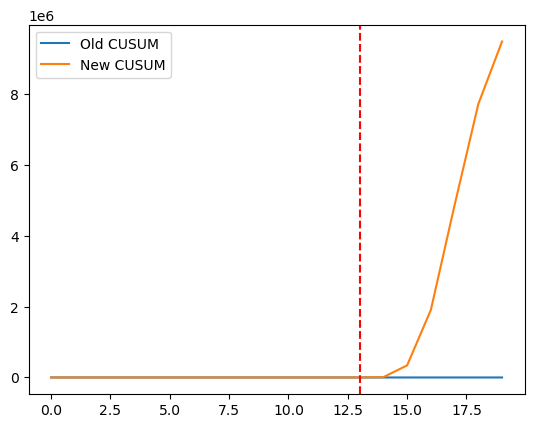

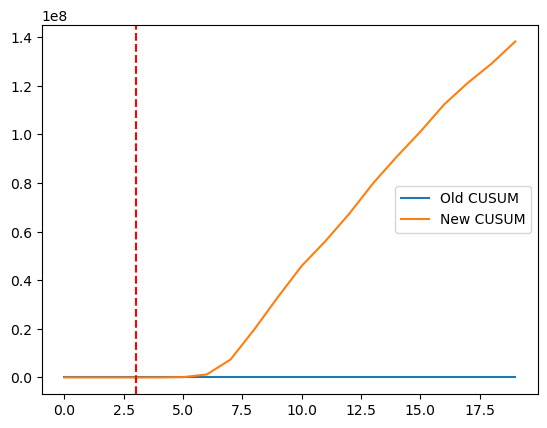

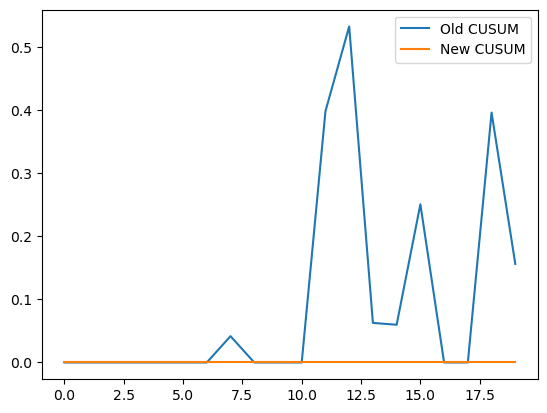

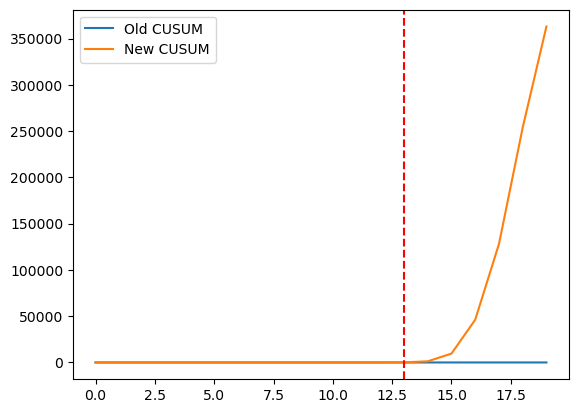

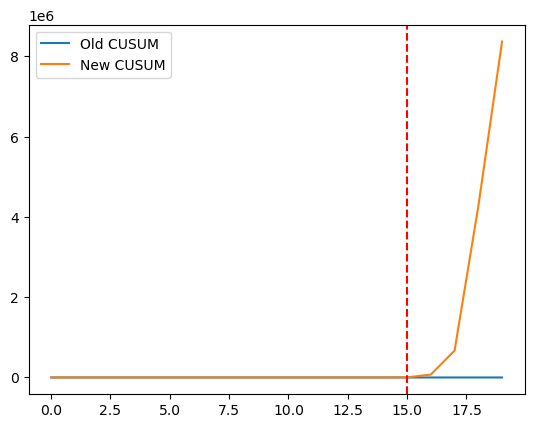

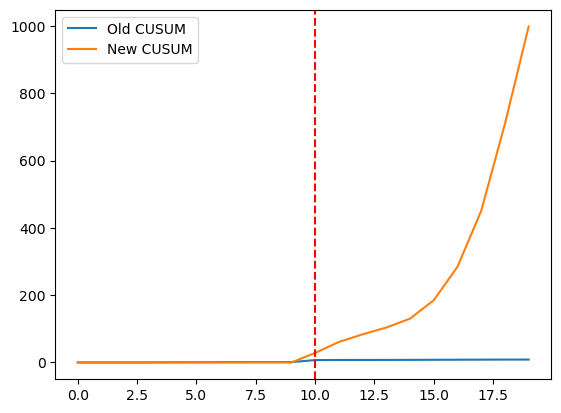

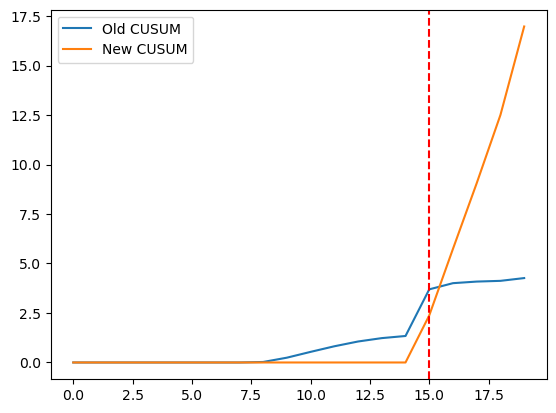

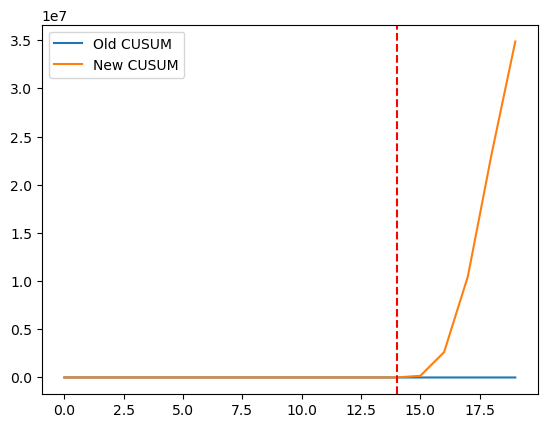

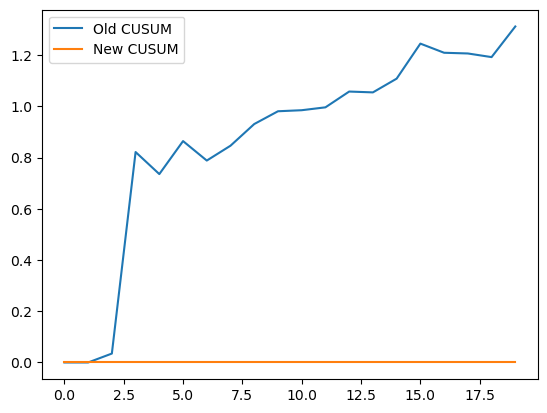

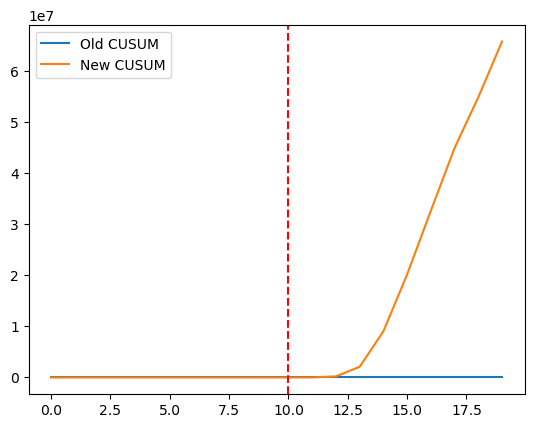

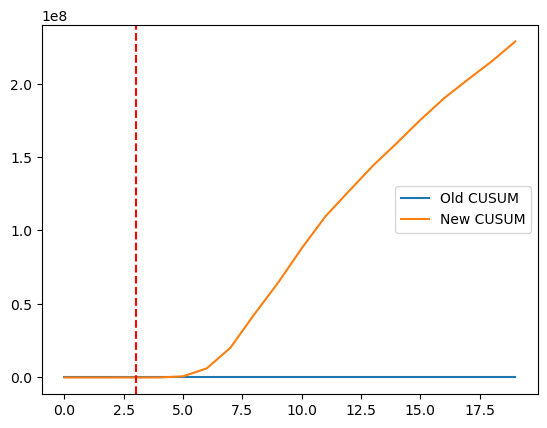

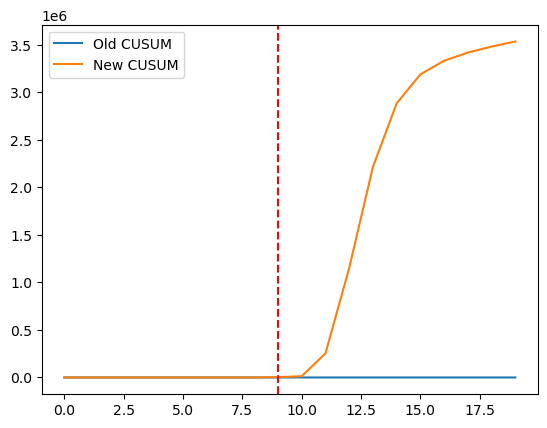

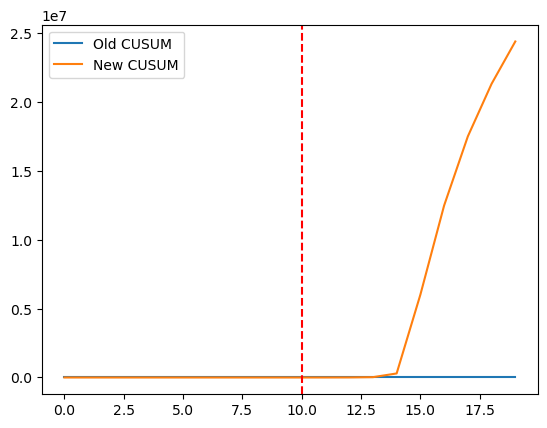

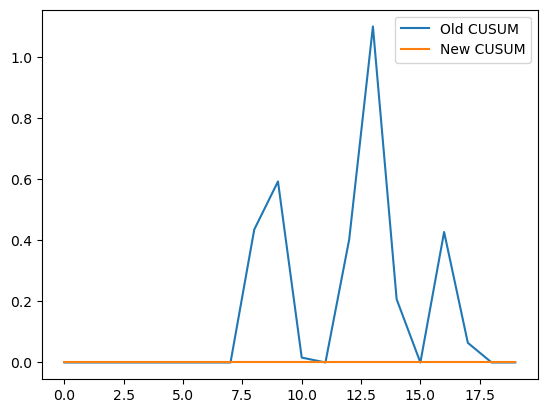

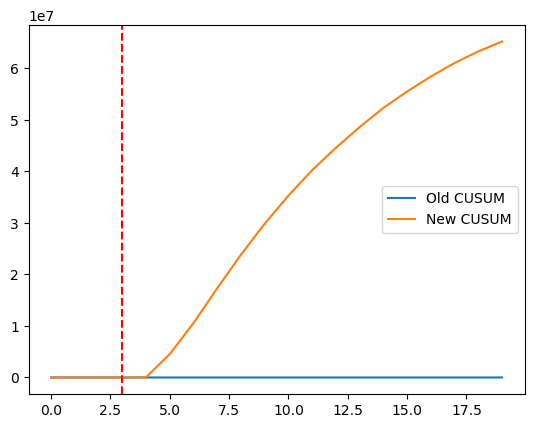

In [25]:
for IDX in range(20):

    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure()
    plt.plot(old_cusum[IDX], label="Old CUSUM")
    plt.plot(new_cusum[IDX], label="New CUSUM")
    if change_idx > 0:
        plt.axvline(x = change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

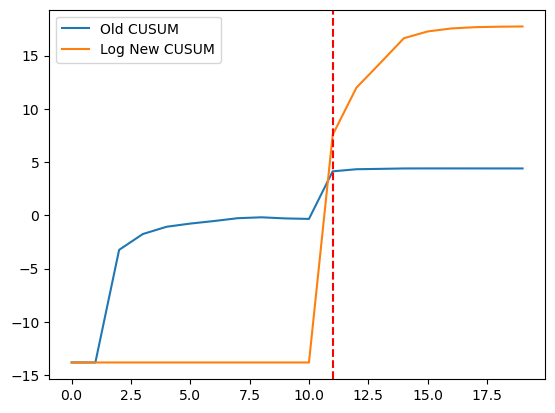

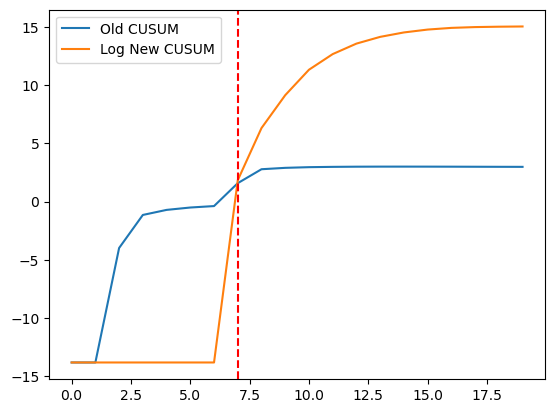

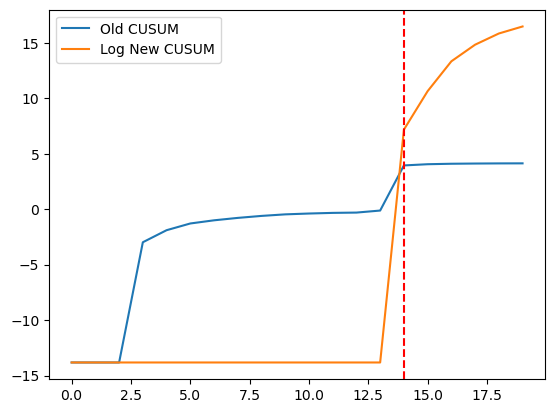

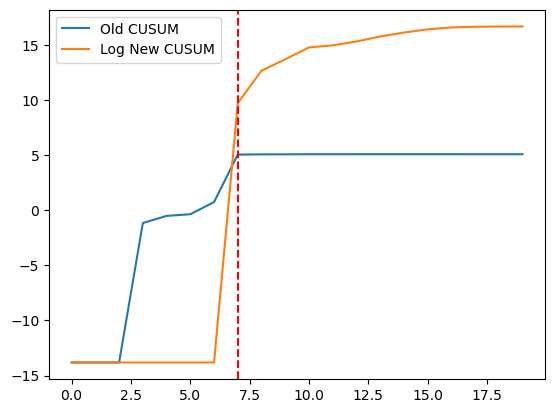

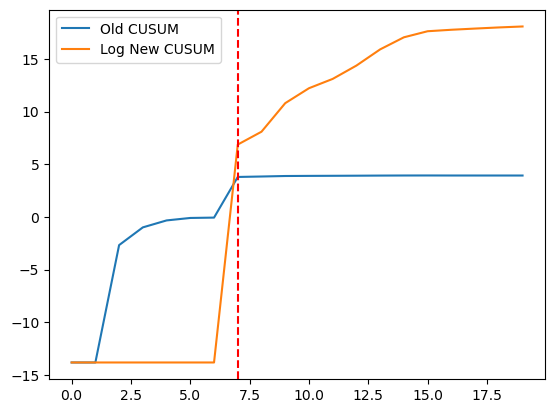

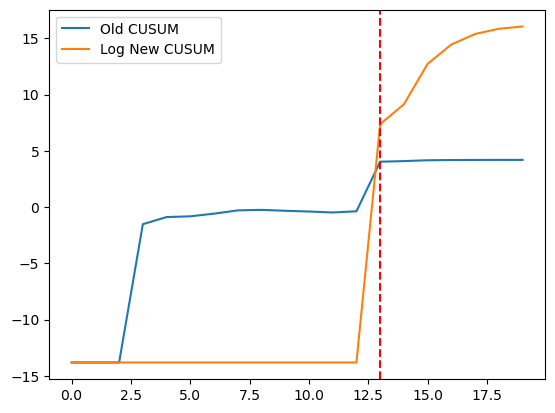

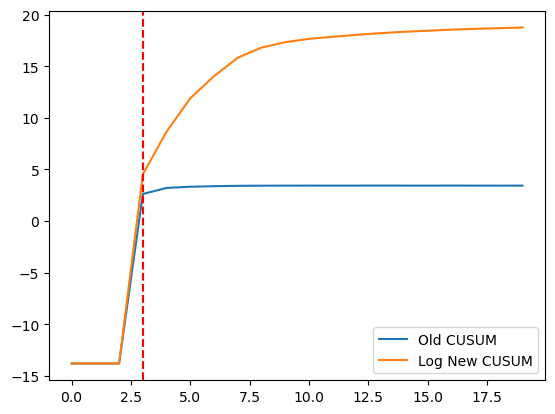

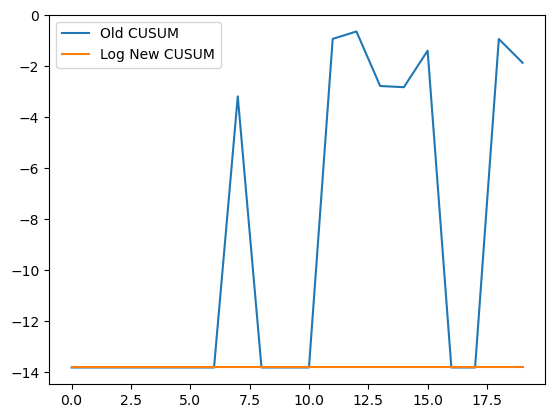

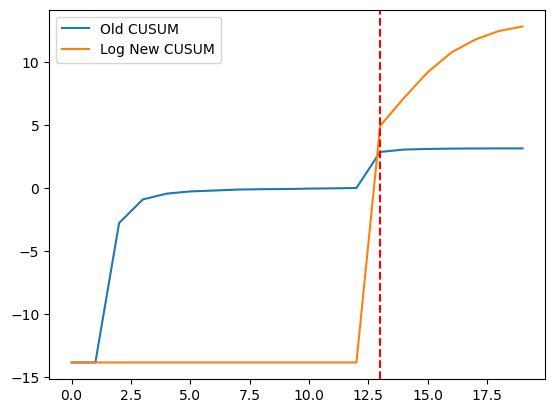

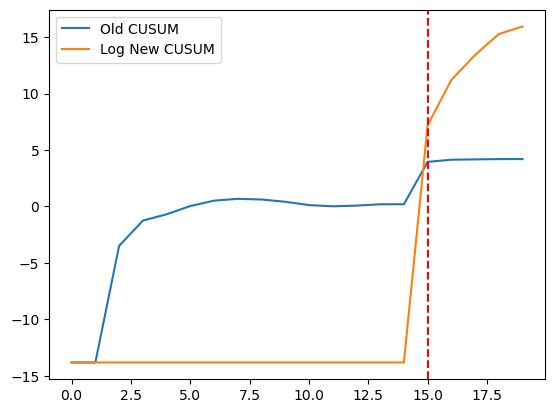

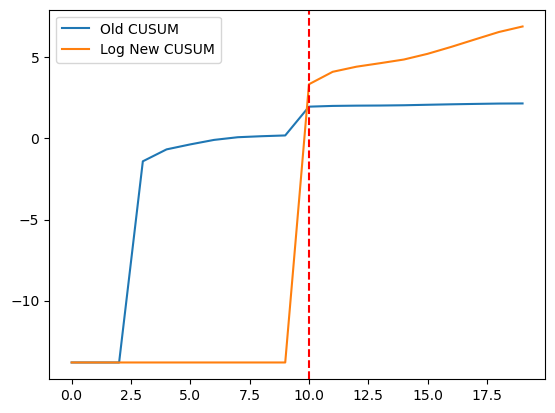

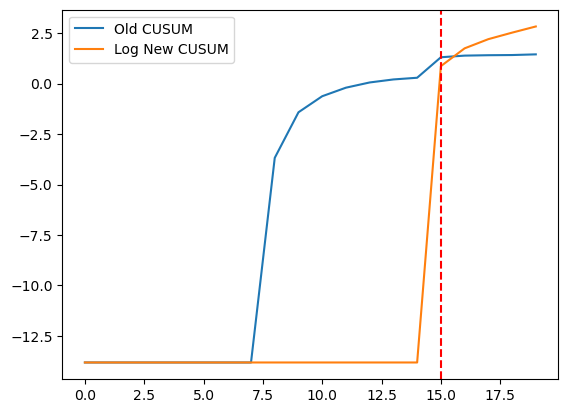

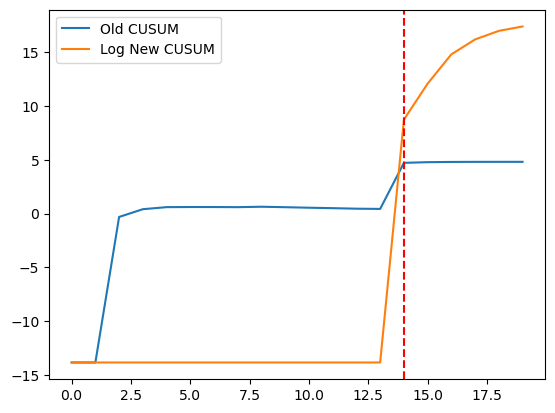

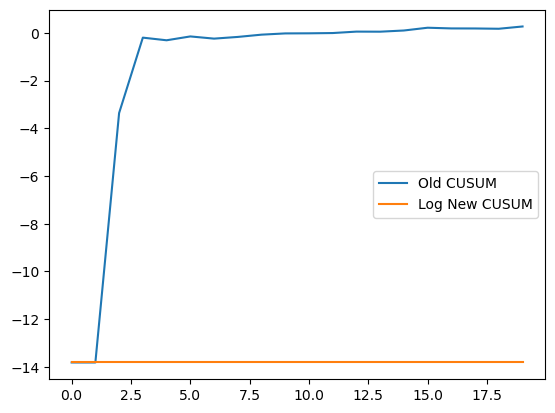

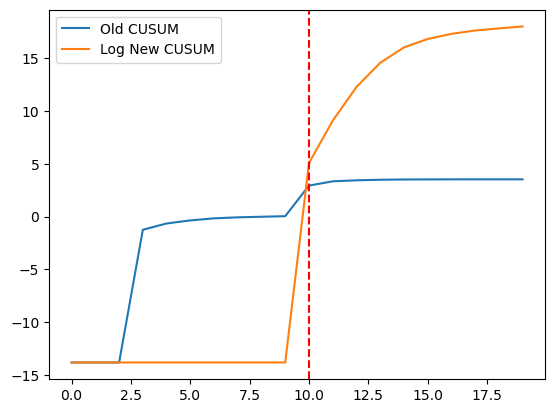

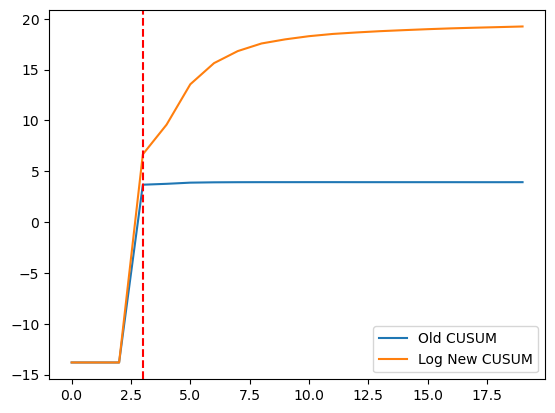

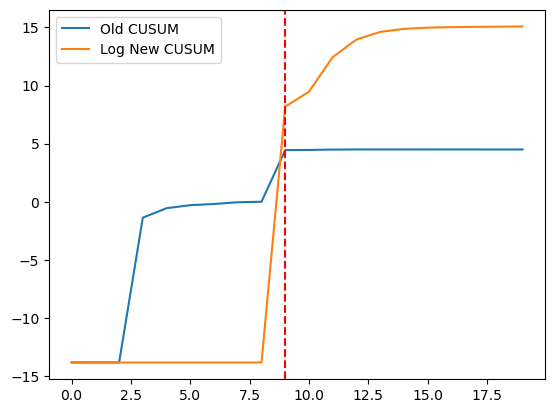

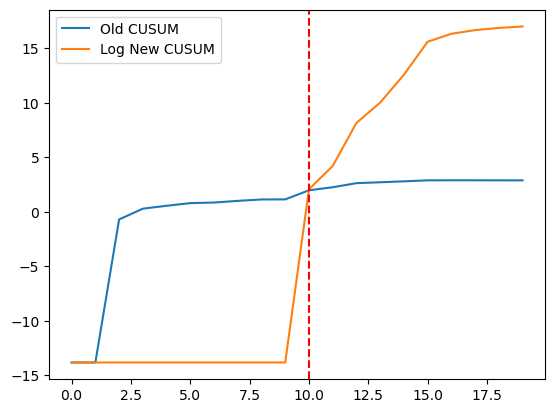

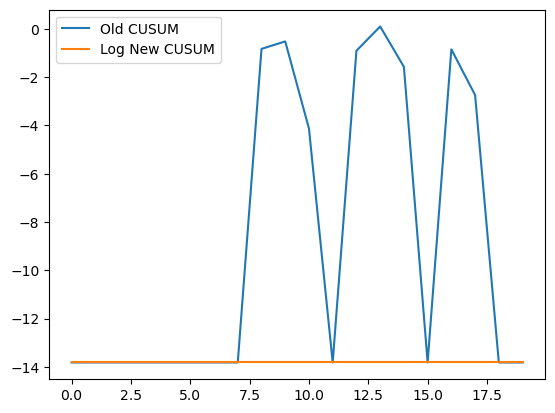

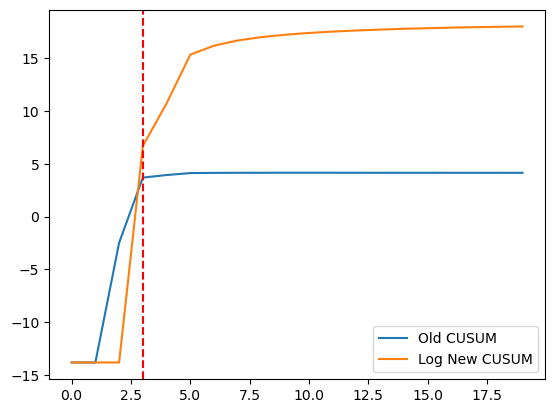

In [30]:
for IDX in range(20):

    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure()
    plt.plot(torch.log(old_cusum[IDX] + 1e-6), label="Old CUSUM")
    # plt.plot(new_cusum[IDX], label="New CUSUM")
    plt.plot(torch.log(new_cusum[IDX] + 1e-6), label="Log New CUSUM")
    if change_idx > 0:
        plt.axvline(x = change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

In [10]:
def NEW_cusum_detector(
    series_mean: torch.Tensor, series_std: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    
    normal_to_change_stats = []
        
    for pred_mean, pred_std in zip(preds_mean, preds_std):
        
        normal_to_change_stat = torch.zeros(len(pred_mean)).to(pred_std.device)
    
        for i in range(1, len(pred_mean)):

            t = (pred_mean[i] - 0.5) / pred_std[i] ** 2

            normal_to_change_stat[i] = torch.max(
                normal_to_change_stat[i - 1] + t, normal_to_change_stat[i - 1]
            )
            
        normal_to_change_stats.append(normal_to_change_stat)
    
    normal_to_change_stats = torch.stack(normal_to_change_stats)

    return normal_to_change_stats

In [11]:
new_cusum = NEW_cusum_detector(preds_mean, preds_std)

In [13]:
predictions_old[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [16]:
new_cusum[0]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.9629e+00, 4.0242e+01, 3.4347e+02, 2.0666e+03, 8.6929e+03, 2.7083e+04,
        6.6504e+04, 1.3364e+05, 2.2918e+05, 3.5126e+05, 4.9751e+05, 6.6410e+05,
        8.4698e+05, 1.0403e+06, 1.2391e+06, 1.4398e+06, 1.6395e+06, 1.8558e+06,
        2.1109e+06, 2.4234e+06, 2.7978e+06, 3.2214e+06, 3.6872e+06, 4.1847e+06,
        4.7173e+06, 5.2937e+06, 5.9376e+06, 6.6775e+06])

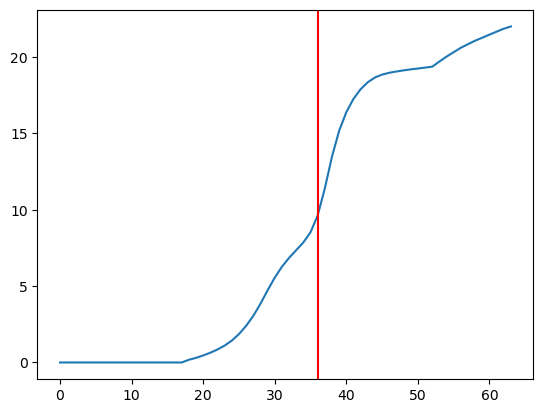

In [17]:
change_idx = labels_batch[0].detach().cpu().numpy().argmax()

plt.plot(old_cusum[0])
plt.axvline(x = change_idx, c="red")

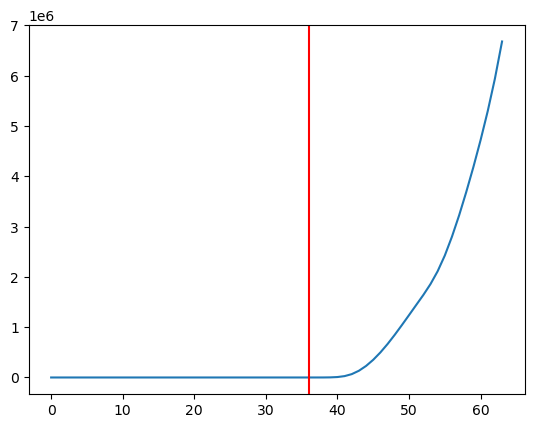

In [18]:
change_idx = labels_batch[0].detach().cpu().numpy().argmax()

plt.plot(new_cusum[0])
plt.axvline(x = change_idx, c="red")

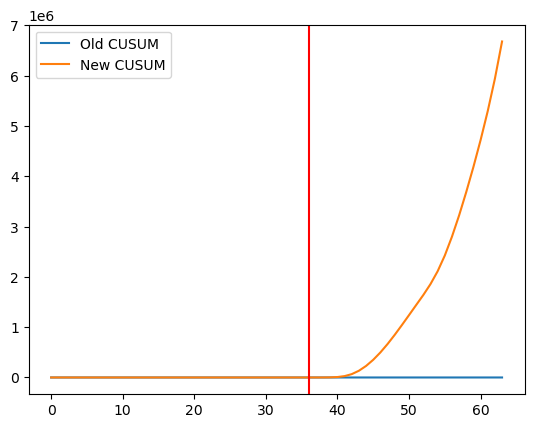

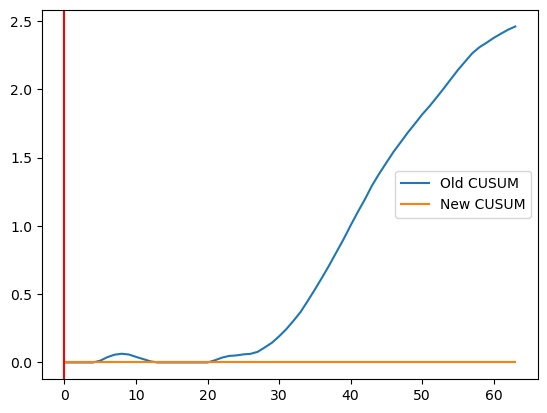

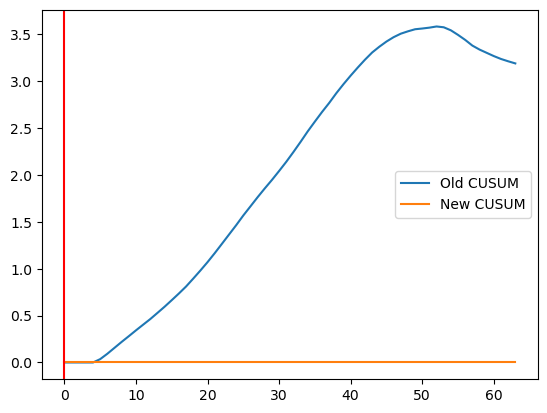

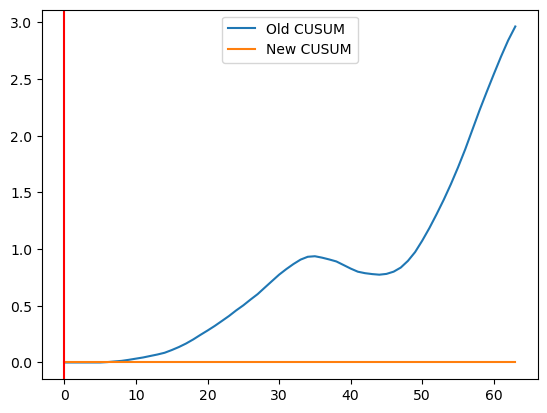

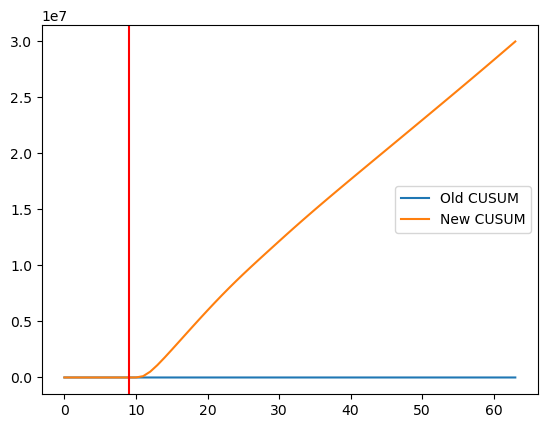

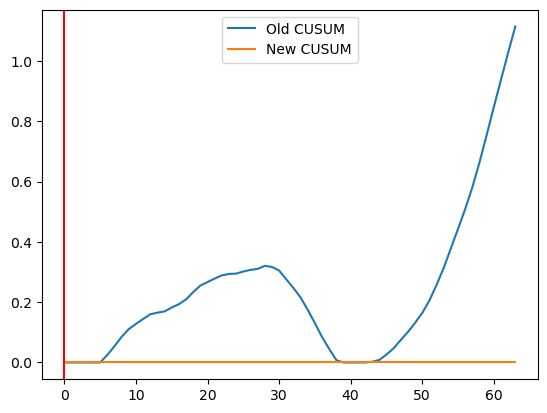

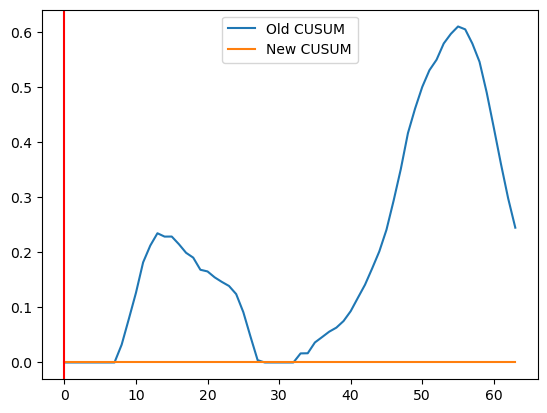

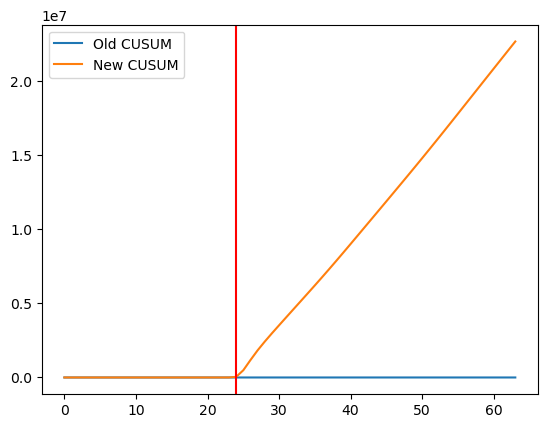

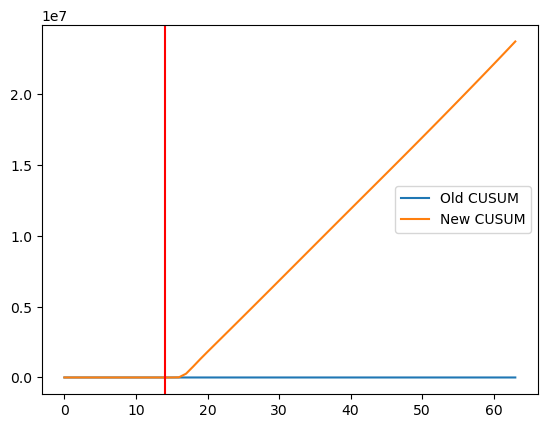

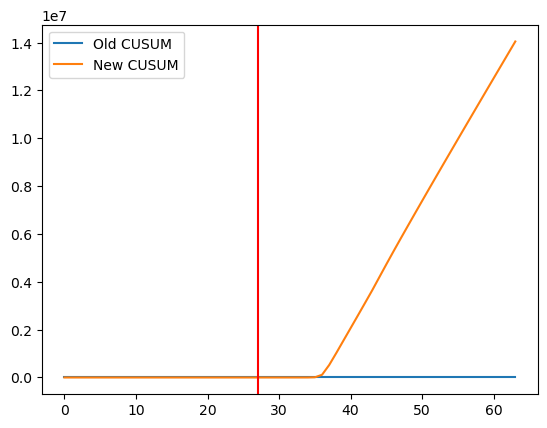

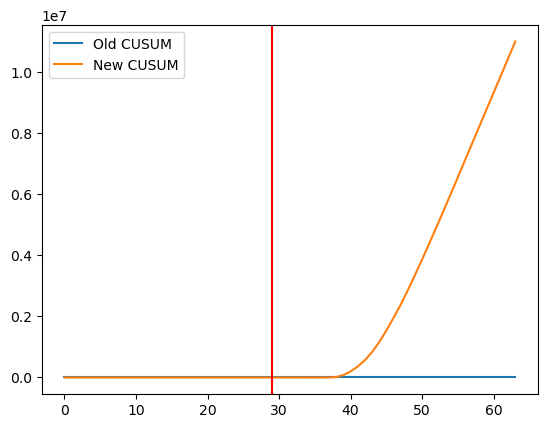

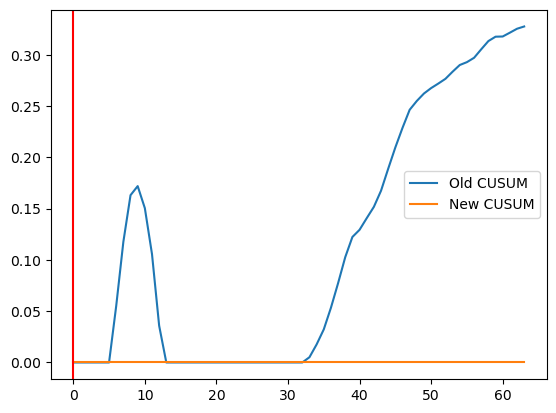

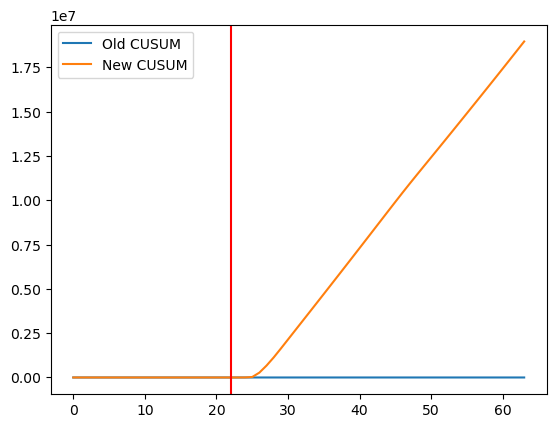

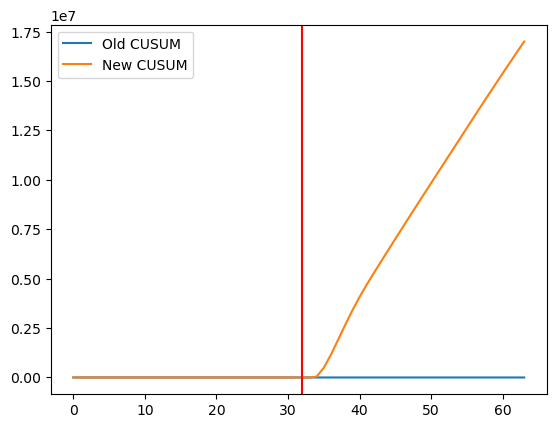

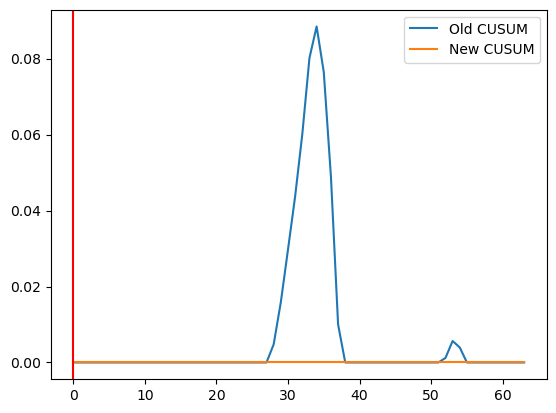

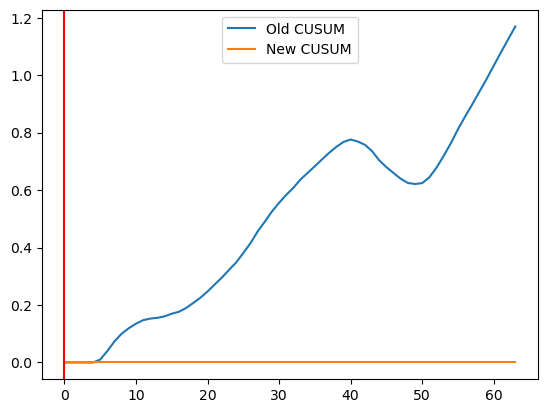

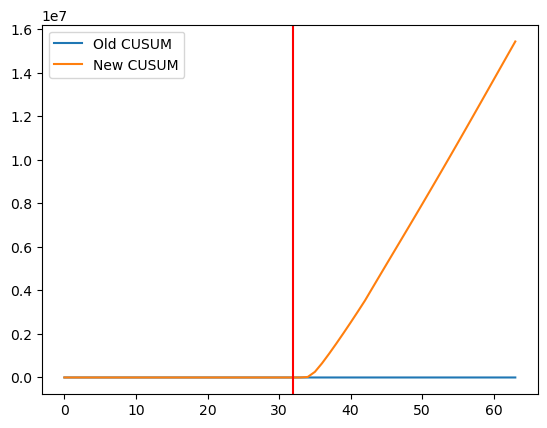

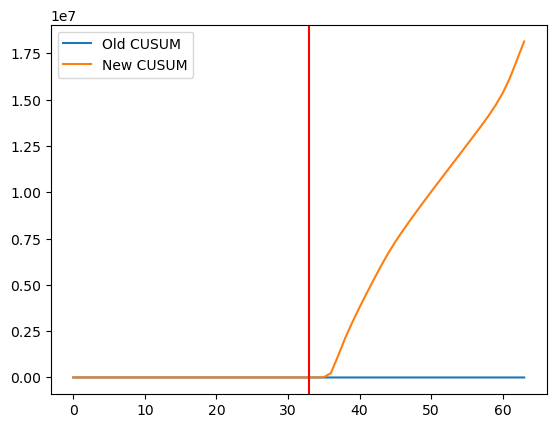

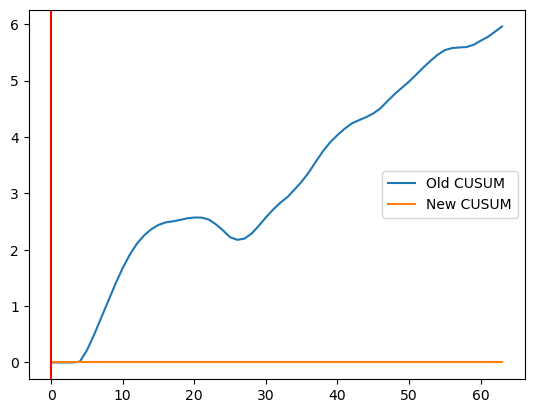

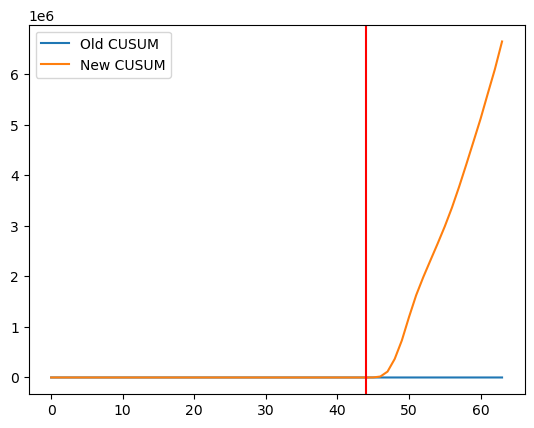

In [89]:
for IDX in range(20):

    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure()
    plt.plot(old_cusum[IDX], label="Old CUSUM")
    plt.plot(new_cusum[IDX], label="New CUSUM")
    plt.axvline(x = change_idx, c="red")
    plt.legend()
    plt.show()

## HAR

In [19]:
model_type = "seq2seq"
experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["loss_type"] = "bce"
args_config["num_workers"] = 2
args_config["learning"]["gpus"] = 1
args_config["learning"]["epochs"] = 100

In [20]:
# choose CUSUM alarm threshold
cusum_threshold = 11.5

# Initialize model and load weights
ens_har_bce_cusum = CusumEnsembleCPDModel(args_config, n_models=10, cusum_threshold=cusum_threshold)
ens_har_bce_cusum.load_models_list("saved_models/human_activity/full_sample")

# create test_dataset and test_dataloader
test_dataset = ens_har_bce_cusum.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size = args_config["learning"]["batch_size"], shuffle=True)

In [22]:
seq_batch, labels_batch = next(iter(test_dataloader))

_ = ens_har_bce_cusum.predict(seq_batch)

preds_mean = ens_har_bce_cusum.preds_mean.detach().cpu()
preds_std = ens_har_bce_cusum.preds_std.detach().cpu()
old_cusum = ens_har_bce_cusum.normal_to_change_stats.detach().cpu()
predictions_old = ens_har_bce_cusum.change_masks.detach().cpu()

In [23]:
new_cusum = NEW_cusum_detector(preds_mean, preds_std)

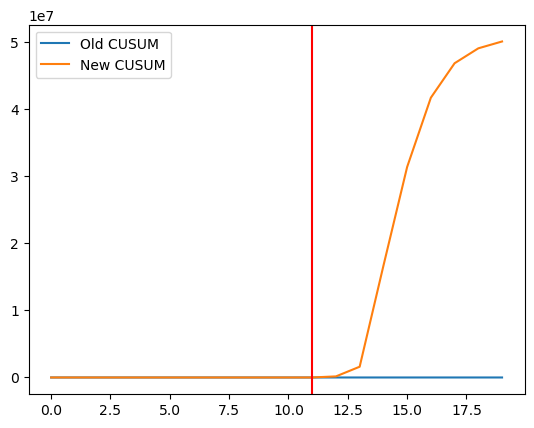

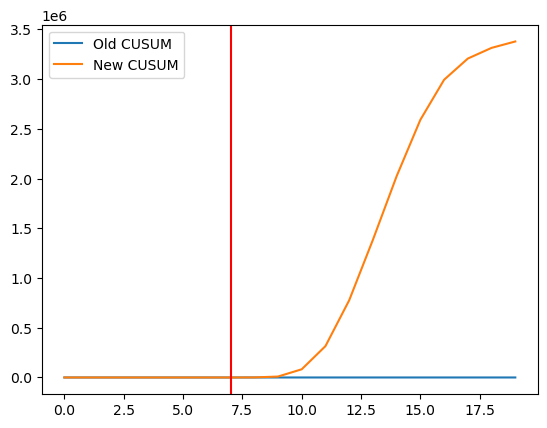

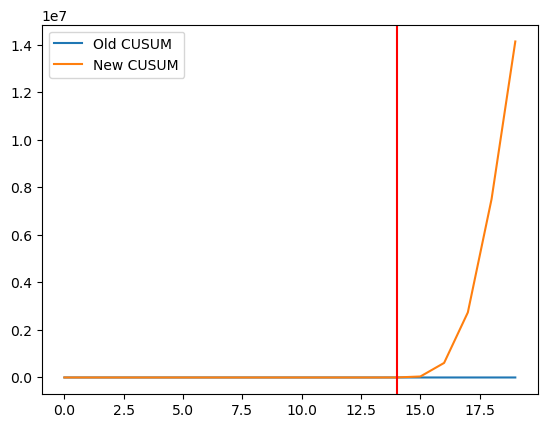

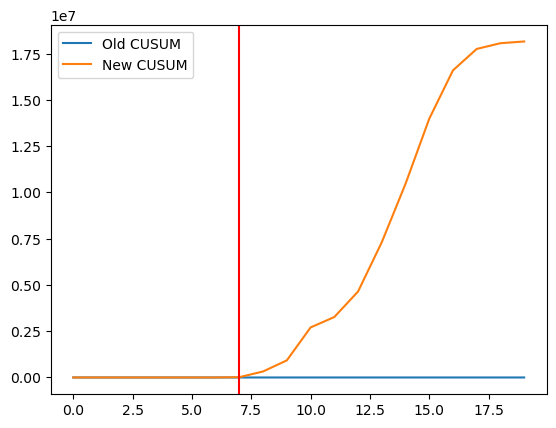

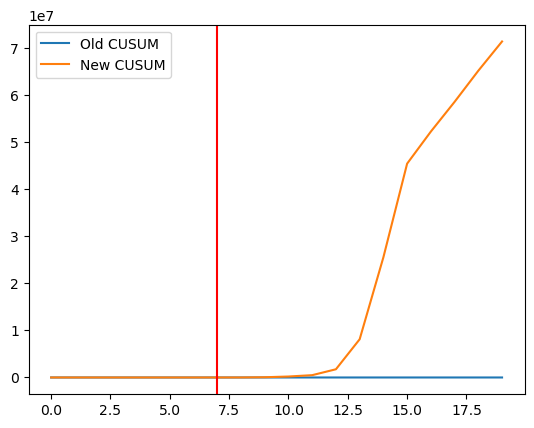

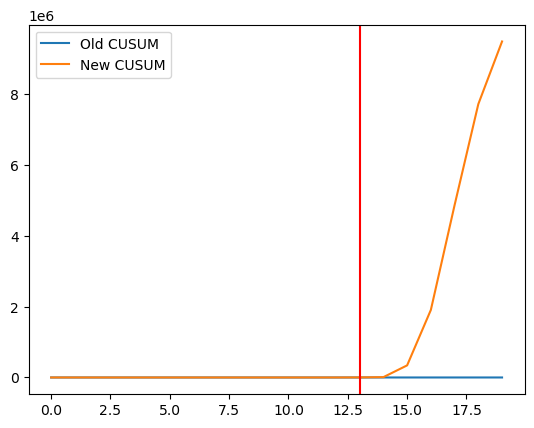

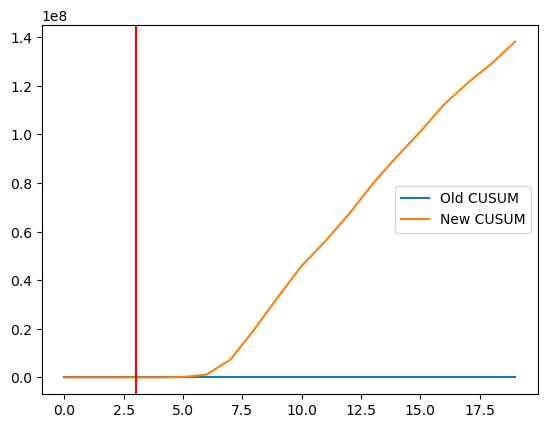

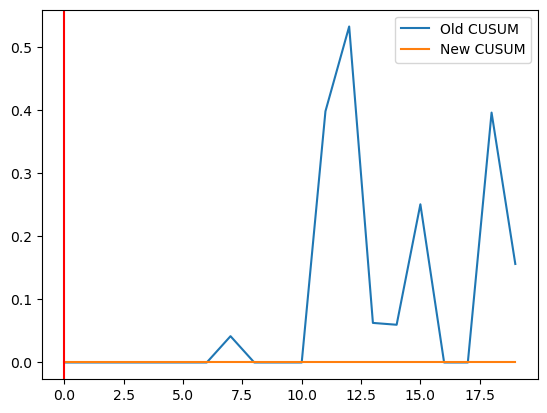

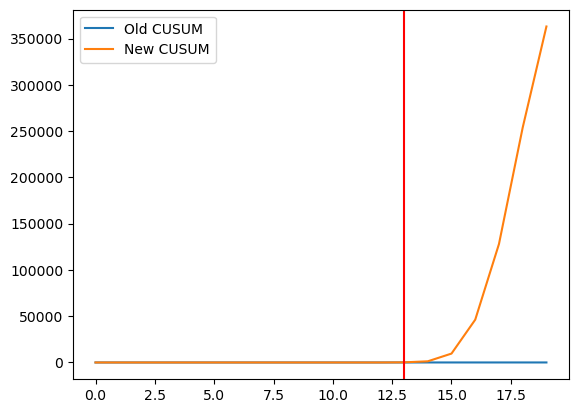

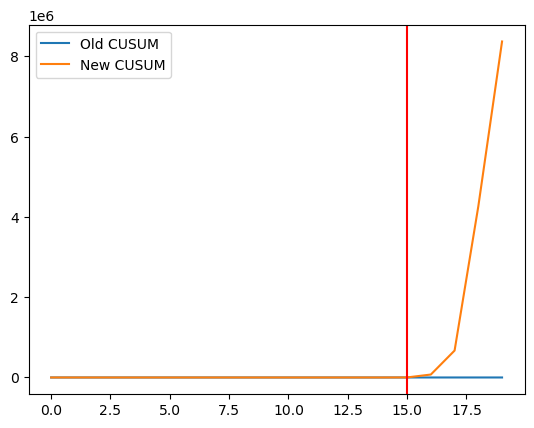

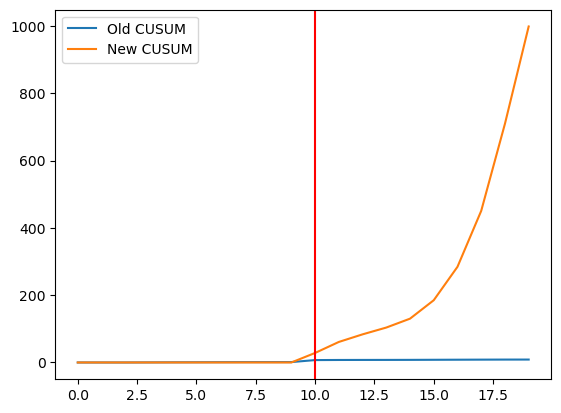

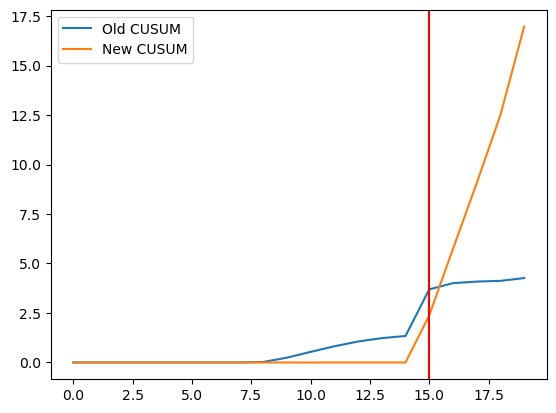

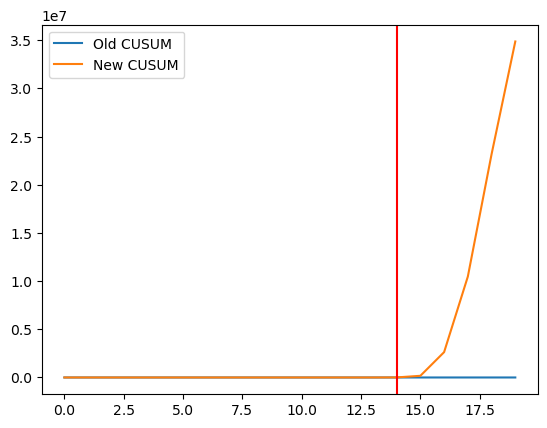

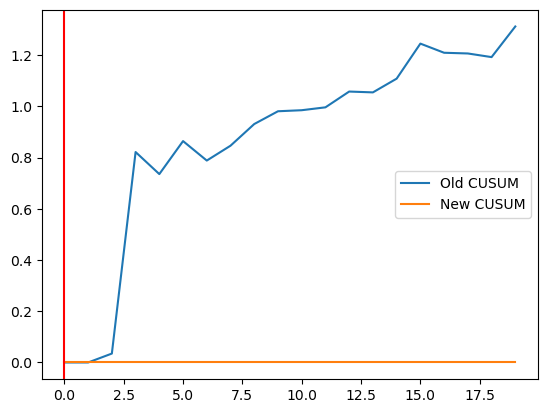

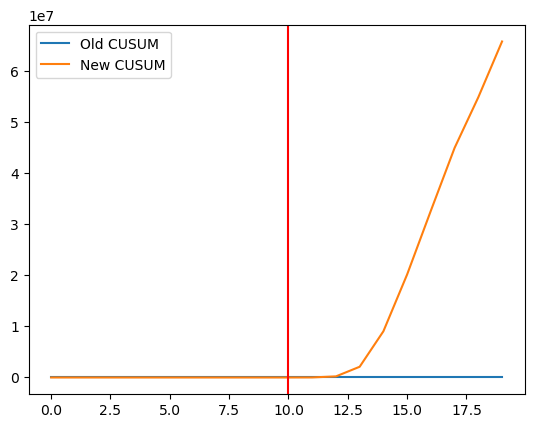

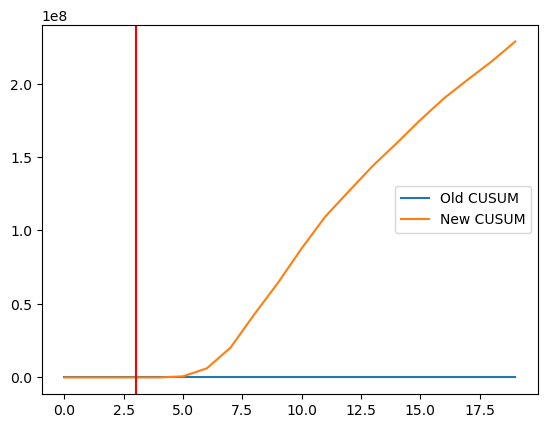

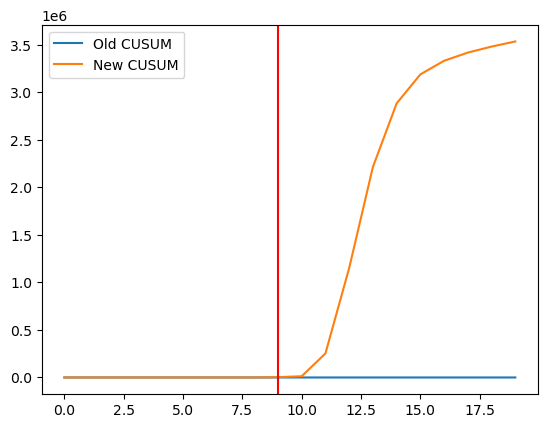

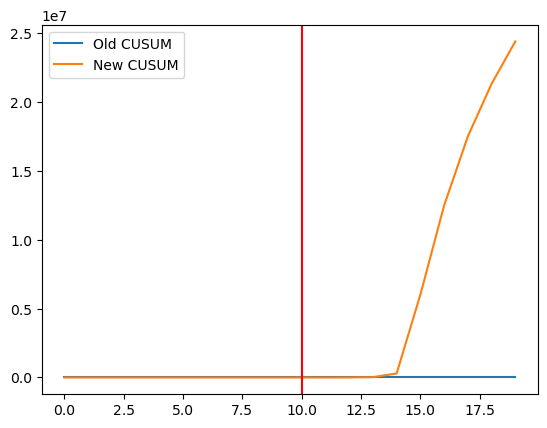

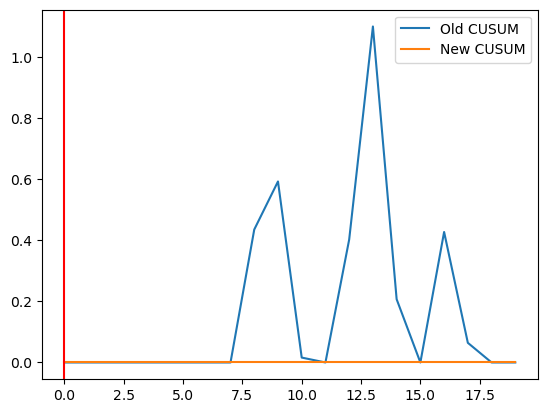

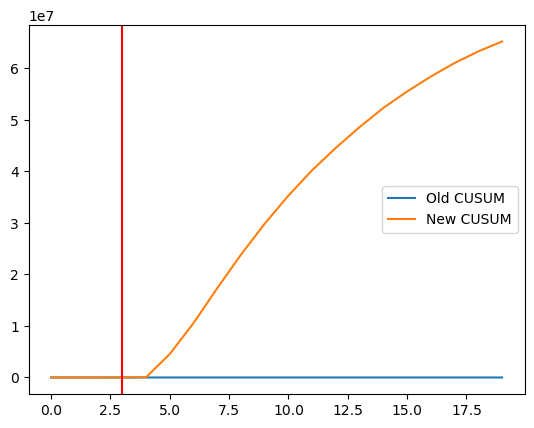

In [24]:
for IDX in range(20):

    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure()
    plt.plot(old_cusum[IDX], label="Old CUSUM")
    plt.plot(new_cusum[IDX], label="New CUSUM")
    plt.axvline(x = change_idx, c="red")
    plt.legend()
    plt.show()